# Contents <a id='back'></a>

* [Introduction](#intro)
* [1. Data Overview](#data_review)
    * [Conclusions](#data_review_conclusions)
* [2. Exploratory Data Analysis](#eda)
    * [2.1 Check the number of movies and reviews over the course of several years](#number_movies_reviews)
    * [2.2 Check the distribution of the number of reviews per movie with accurate counting and KDE (Kernel Density Estimation) (to understand the difference from accurate counting)](#review_distribution_KDE)
    * [2.3 Distribution of negative and positive reviews over the years for two dataset portions.)](#neg_pos_reviews)
* [3. Data PreProcessing](#data_preprocessing)
    * [3.1 Normalization](#normalization)
* [4. Model Training and Evaluation](#model_training_evaluation)
    * [4.1 Splitting the dataset into a training set and a test set](#splitting_dataset)
    * [4.2 Training Model](#training_model)
* [5. Testing the trained model on a self-created reviews dataset](#testing_selfcreated_dataset)
    * [5.1 Testing Mode](#testing_model)
* [General Conclusion](#end)

# Introduction <a id='intro'></a>

In this project, I will train multiple models that can classify both positive and negative reviews and automatically detect negative reviews. Additionally, I will use accuracy score, F1 score, and AUC ROC as evaluation metrics for the models. In the process, I will perform natural language processing using several libraries to compare the evaluation results of the models.


**Objective:**

Determine the best model with a minimum F1 score of 0.85.

**This project will comprise the following steps:**

1. Data Overview
2. Exploratory Data Analysis
3. Data preprocessing
4. Model Training and Evaluation
5. Testing the trained model on a self-created reviews dataset

[Back to Contents](#back)

## 1. Data Overview <a id='data_review'></a>

The steps to be performed are as follows:
1. Checking the number of rows and columns.
2. Checking for missing values.
3. Checking for duplicate data.
4. Checking statistical information in columns with numerical data types.
5. Checking values in columns with categorical data types.

[Back to Contents](#back)

In [2]:
# load library
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# this is to use `progress_apply`, read more at https://pypi.org/project/tqdm/#pandas-integration
from tqdm.auto import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# The following line provides a graph with higher quality on HiDPI screens.
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

### 1.1 Data Exploration: df_reviews dataset

In [4]:
# load data
df_reviews = pd.read_csv('data/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.shape

(47331, 17)

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [9]:
(df_reviews.isnull().sum() / len(df_reviews) * 100).sort_values()

tconst             0.000000
pos                0.000000
sp                 0.000000
rating             0.000000
review             0.000000
ds_part            0.000000
is_adult           0.000000
genres             0.000000
end_year           0.000000
start_year         0.000000
original_title     0.000000
primary_title      0.000000
title_type         0.000000
runtime_minutes    0.000000
idx                0.000000
average_rating     0.004226
votes              0.004226
dtype: float64

In [10]:
df_reviews.duplicated().sum()

0

### 1.2 Conclusion of Data Overview process <a id='data_review_conclusions'></a>

1. There are missing values in the `average_rating` and `votes` columns with a very small percentage (0.42%).
2. There is no duplicated data.
3. Column names are standardized.

[Back to Contents](#back)

## 2. Exploratory Data Analysis <a id='eda'></a>

### 2.1 Check the number of movies and reviews over the course of several years <a id='number_movies_reviews'></a>

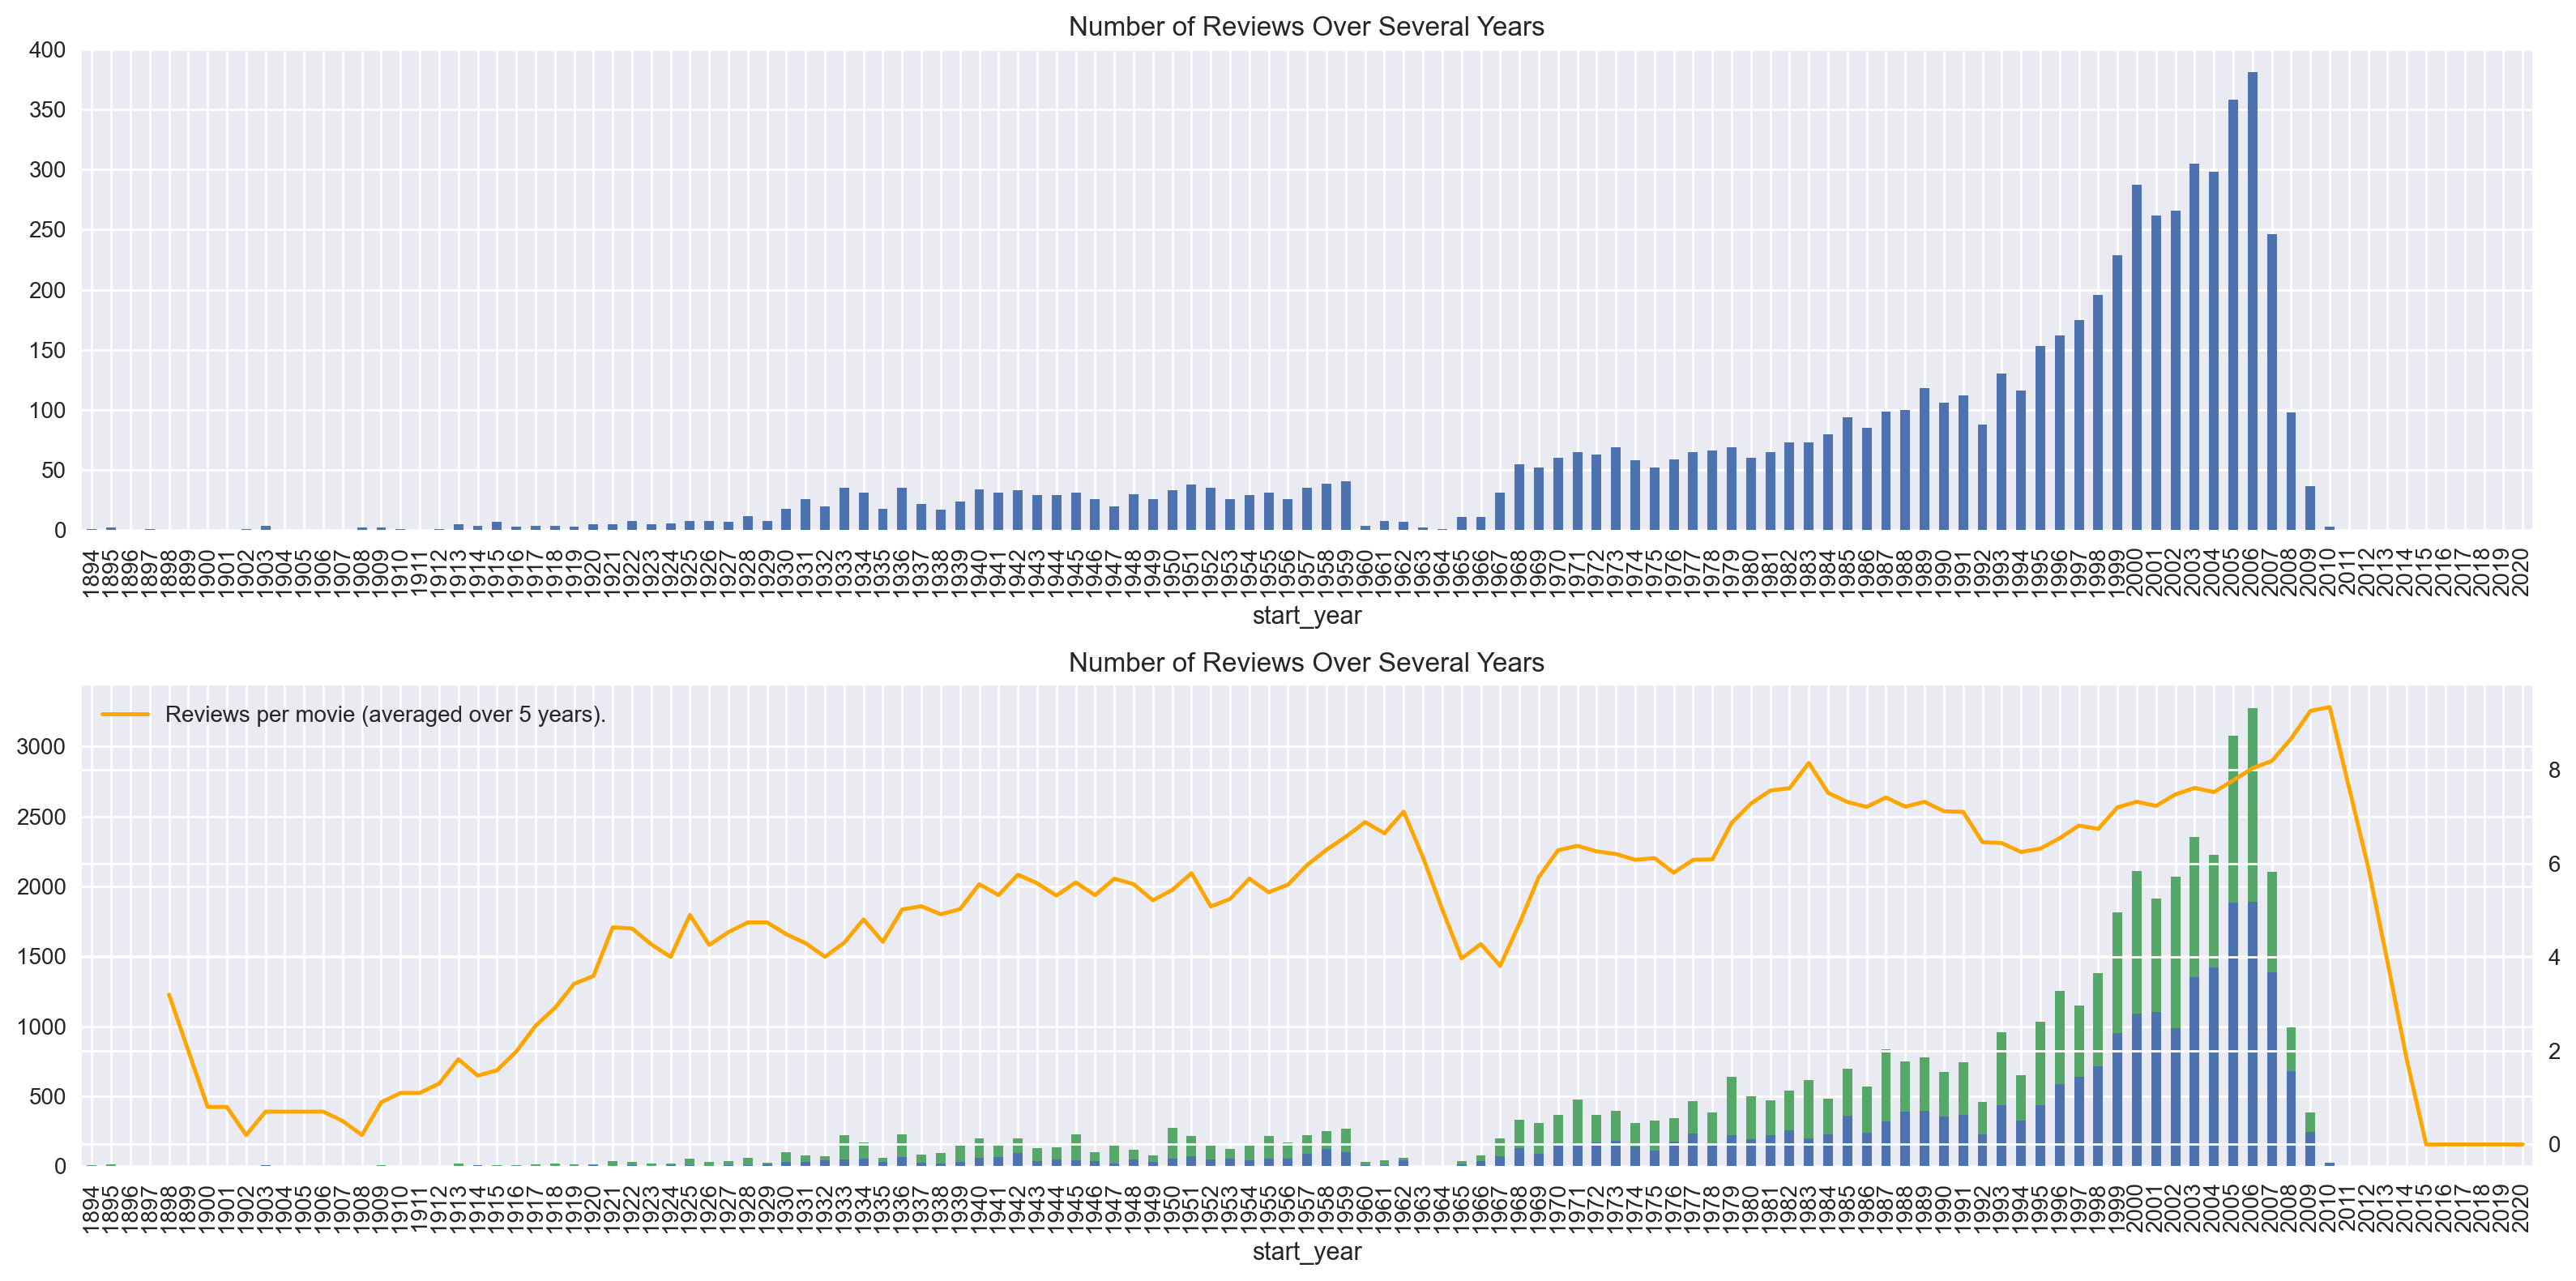

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Reviews Over Several Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='Reviews per movie (averaged over 5 years).', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Several Years') 

fig.tight_layout()

**Findings**

1. From the first graph titled 'Number of Movies Over Several Years,' it can be observed that the year 2016 had the highest number of movies, with a value of nearly 400. This is followed by the year 2005 with a value above 350 and 2003 with a value of 300.
2. From the second graph titled 'Number of Reviews Over Several Years,' it can be observed that the year 2016 had the highest number of reviews per movie, with a value of around 3400 reviews. This is followed by the year 2005 with a value around 3050 and 2003 with a value around 2800.

### 2.2 Check the distribution of the number of reviews per movie with accurate counting and KDE (Kernel Density Estimation) (to understand the difference from accurate counting) <a id='review_distribution_KDE'></a>

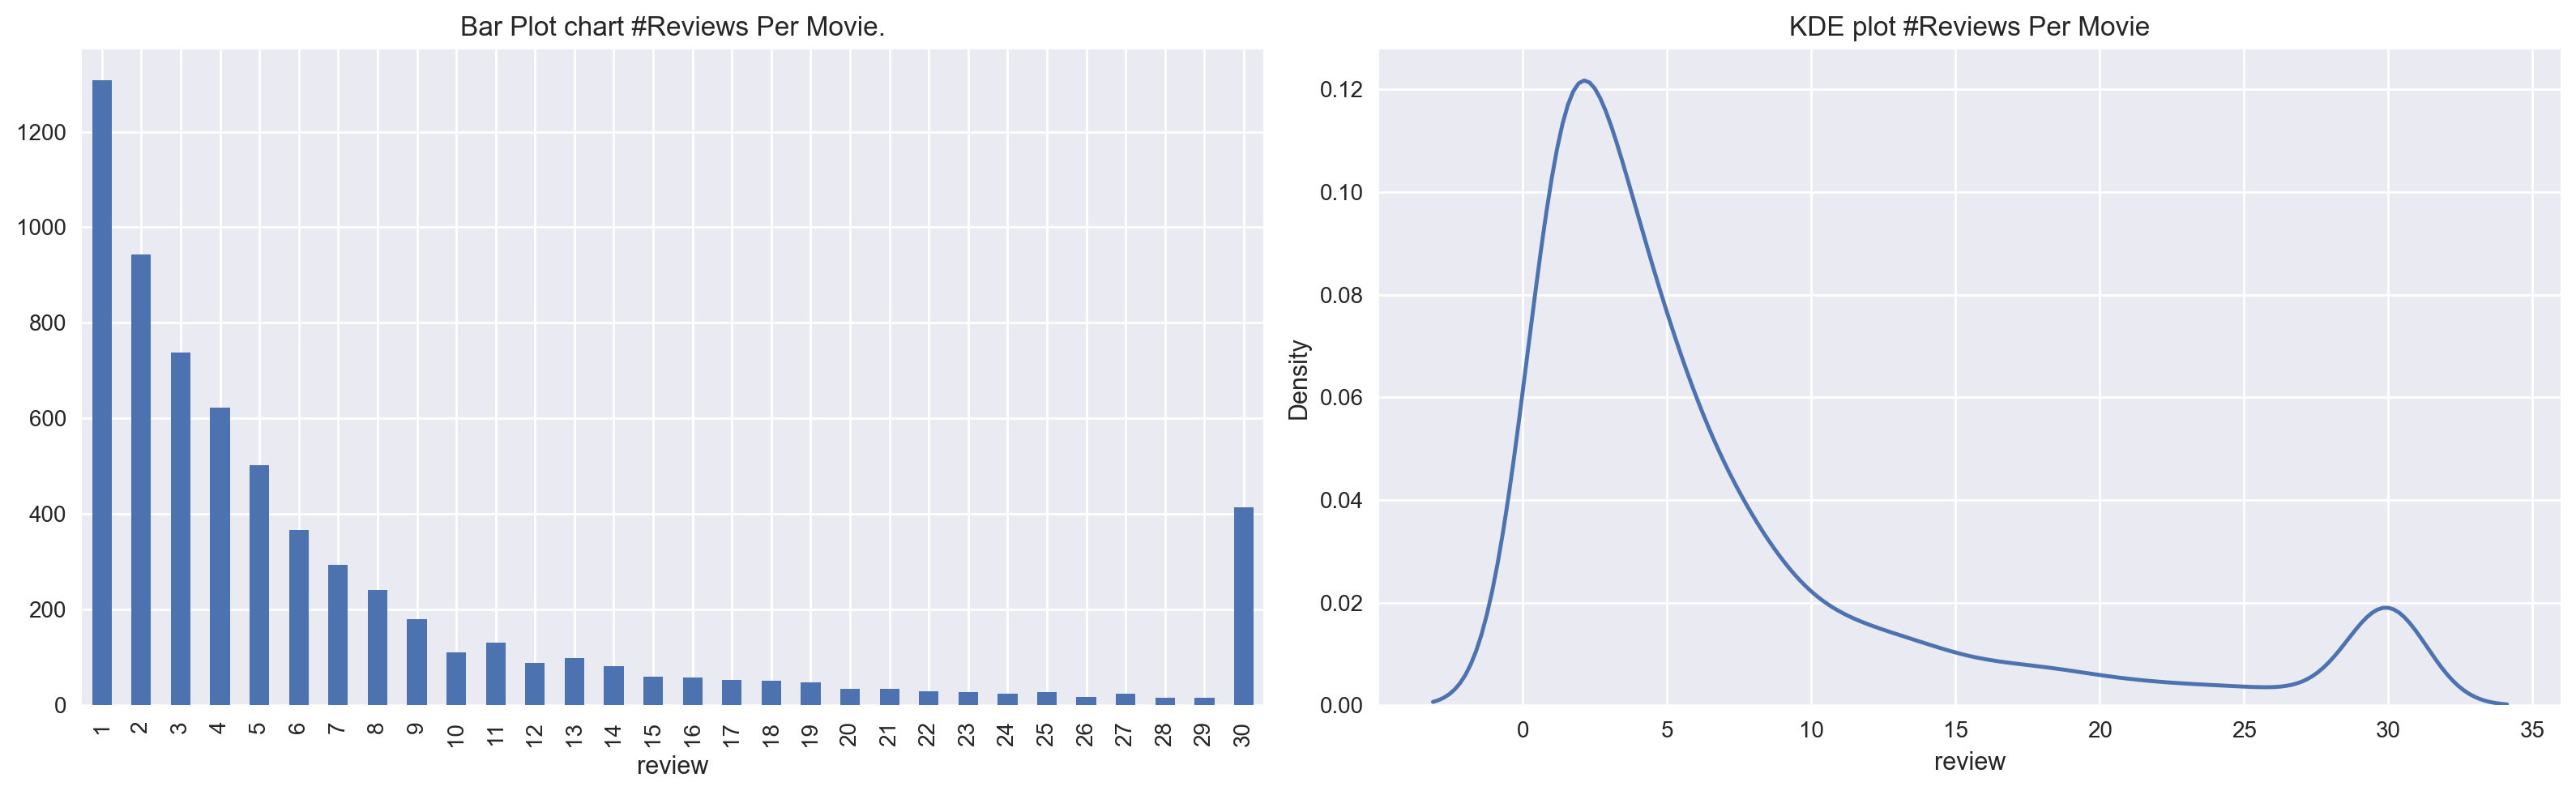

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot chart #Reviews Per Movie.')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE plot #Reviews Per Movie') 

fig.tight_layout()

**Findings**

1. From the distribution plot of the number of reviews per movie above, it can be observed that the highest number of reviews per movie is the value 1, with a count of around 1300.
2. From the distribution plot of the KDE for the number of reviews per movie, it can be seen that the value 1 has the highest density value, with a density of around 0.12.
3. As additional information, KDE plots are used to visualize the probability distribution of continuous data. KDE is employed to estimate the probability density function of unknown data.

In [13]:
# checking data composition of 'pos' column
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

In [14]:
# checking data composition of 'ds_part' column
df_reviews['ds_part'].value_counts()

ds_part
train    23796
test     23535
Name: count, dtype: int64

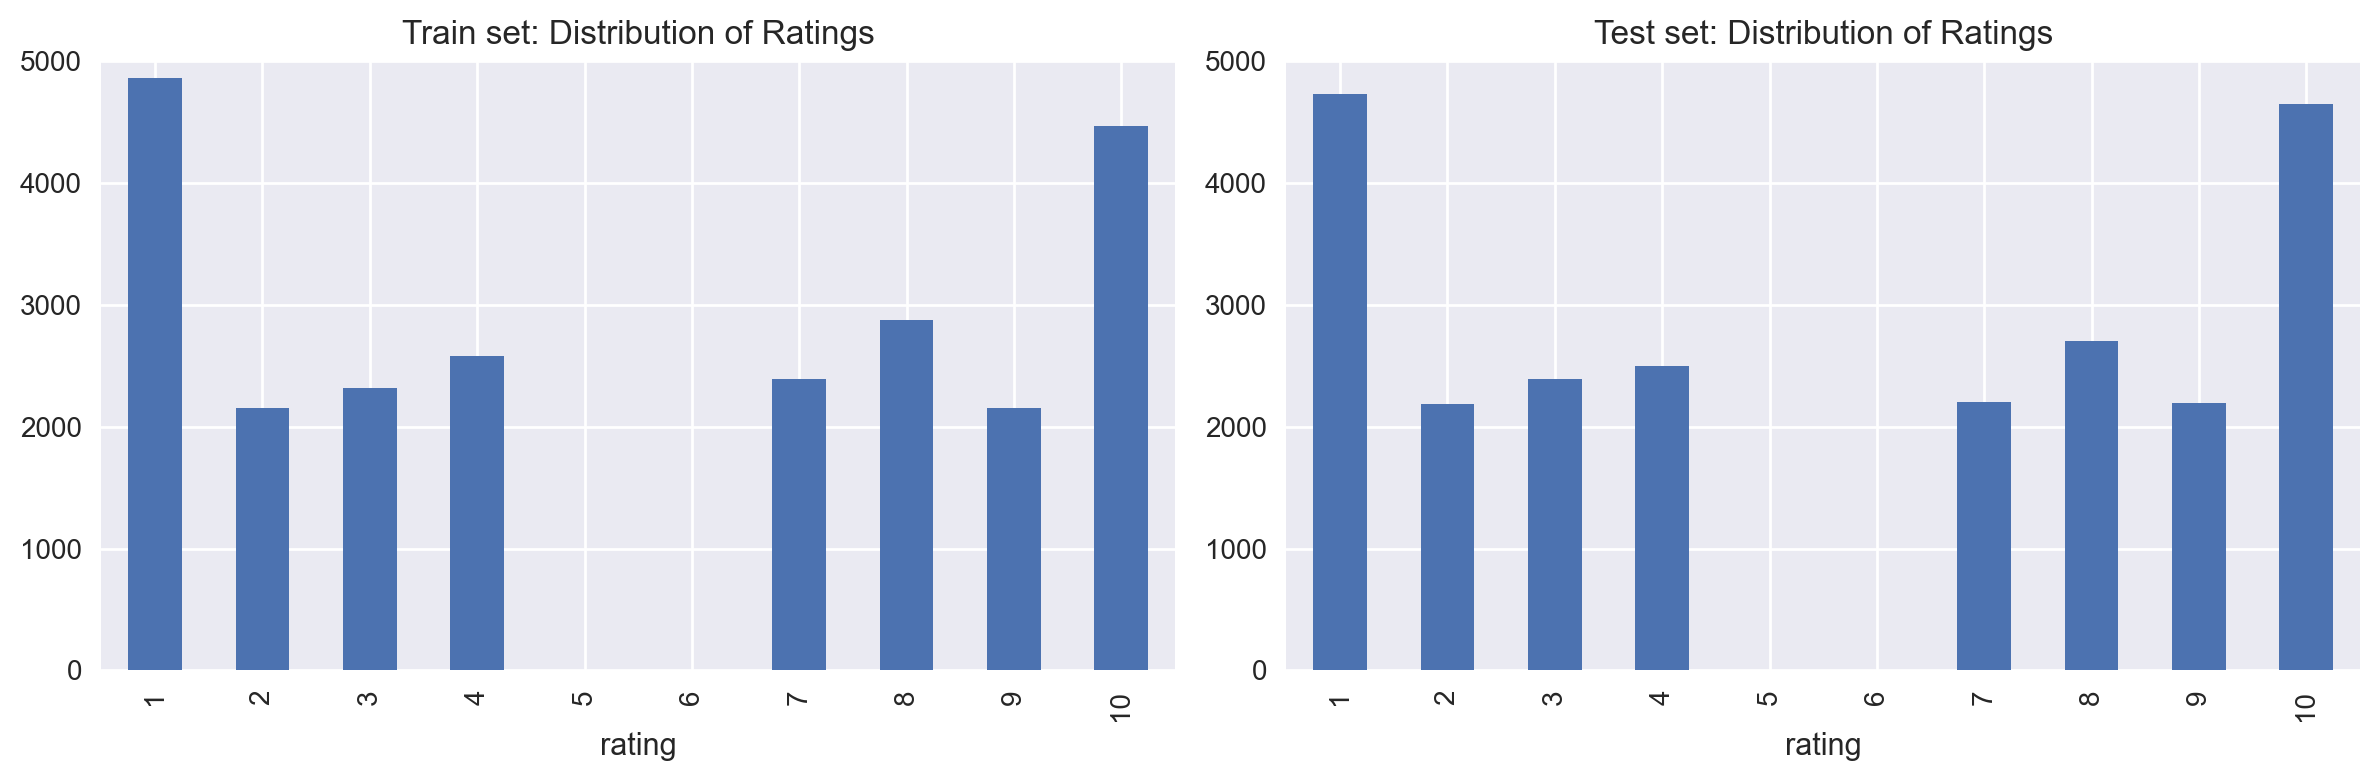

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: Distribution of Ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: Distribution of Ratings')

fig.tight_layout()

**Findings**

1. From the two graphs above, both the Train Set and Test Set have the same distribution of data. 
2. The highest rating is 1, with a count of nearly 5000, followed by rating 10 with a count around 4500. 
3. The next rankings are 8 and 4. 
4. Rankings 3 and 7 have a difference in order between the train set and test set. 
5. In the train set, rating 7 is higher than rating 3, but in the test set, rating 3 is higher than rating 7. Following those, we have rating 2 and lastly, rating 9.

### 2.3 Distribution of negative and positive reviews over the years for two dataset portions <a id='neg_pos_reviews'></a>

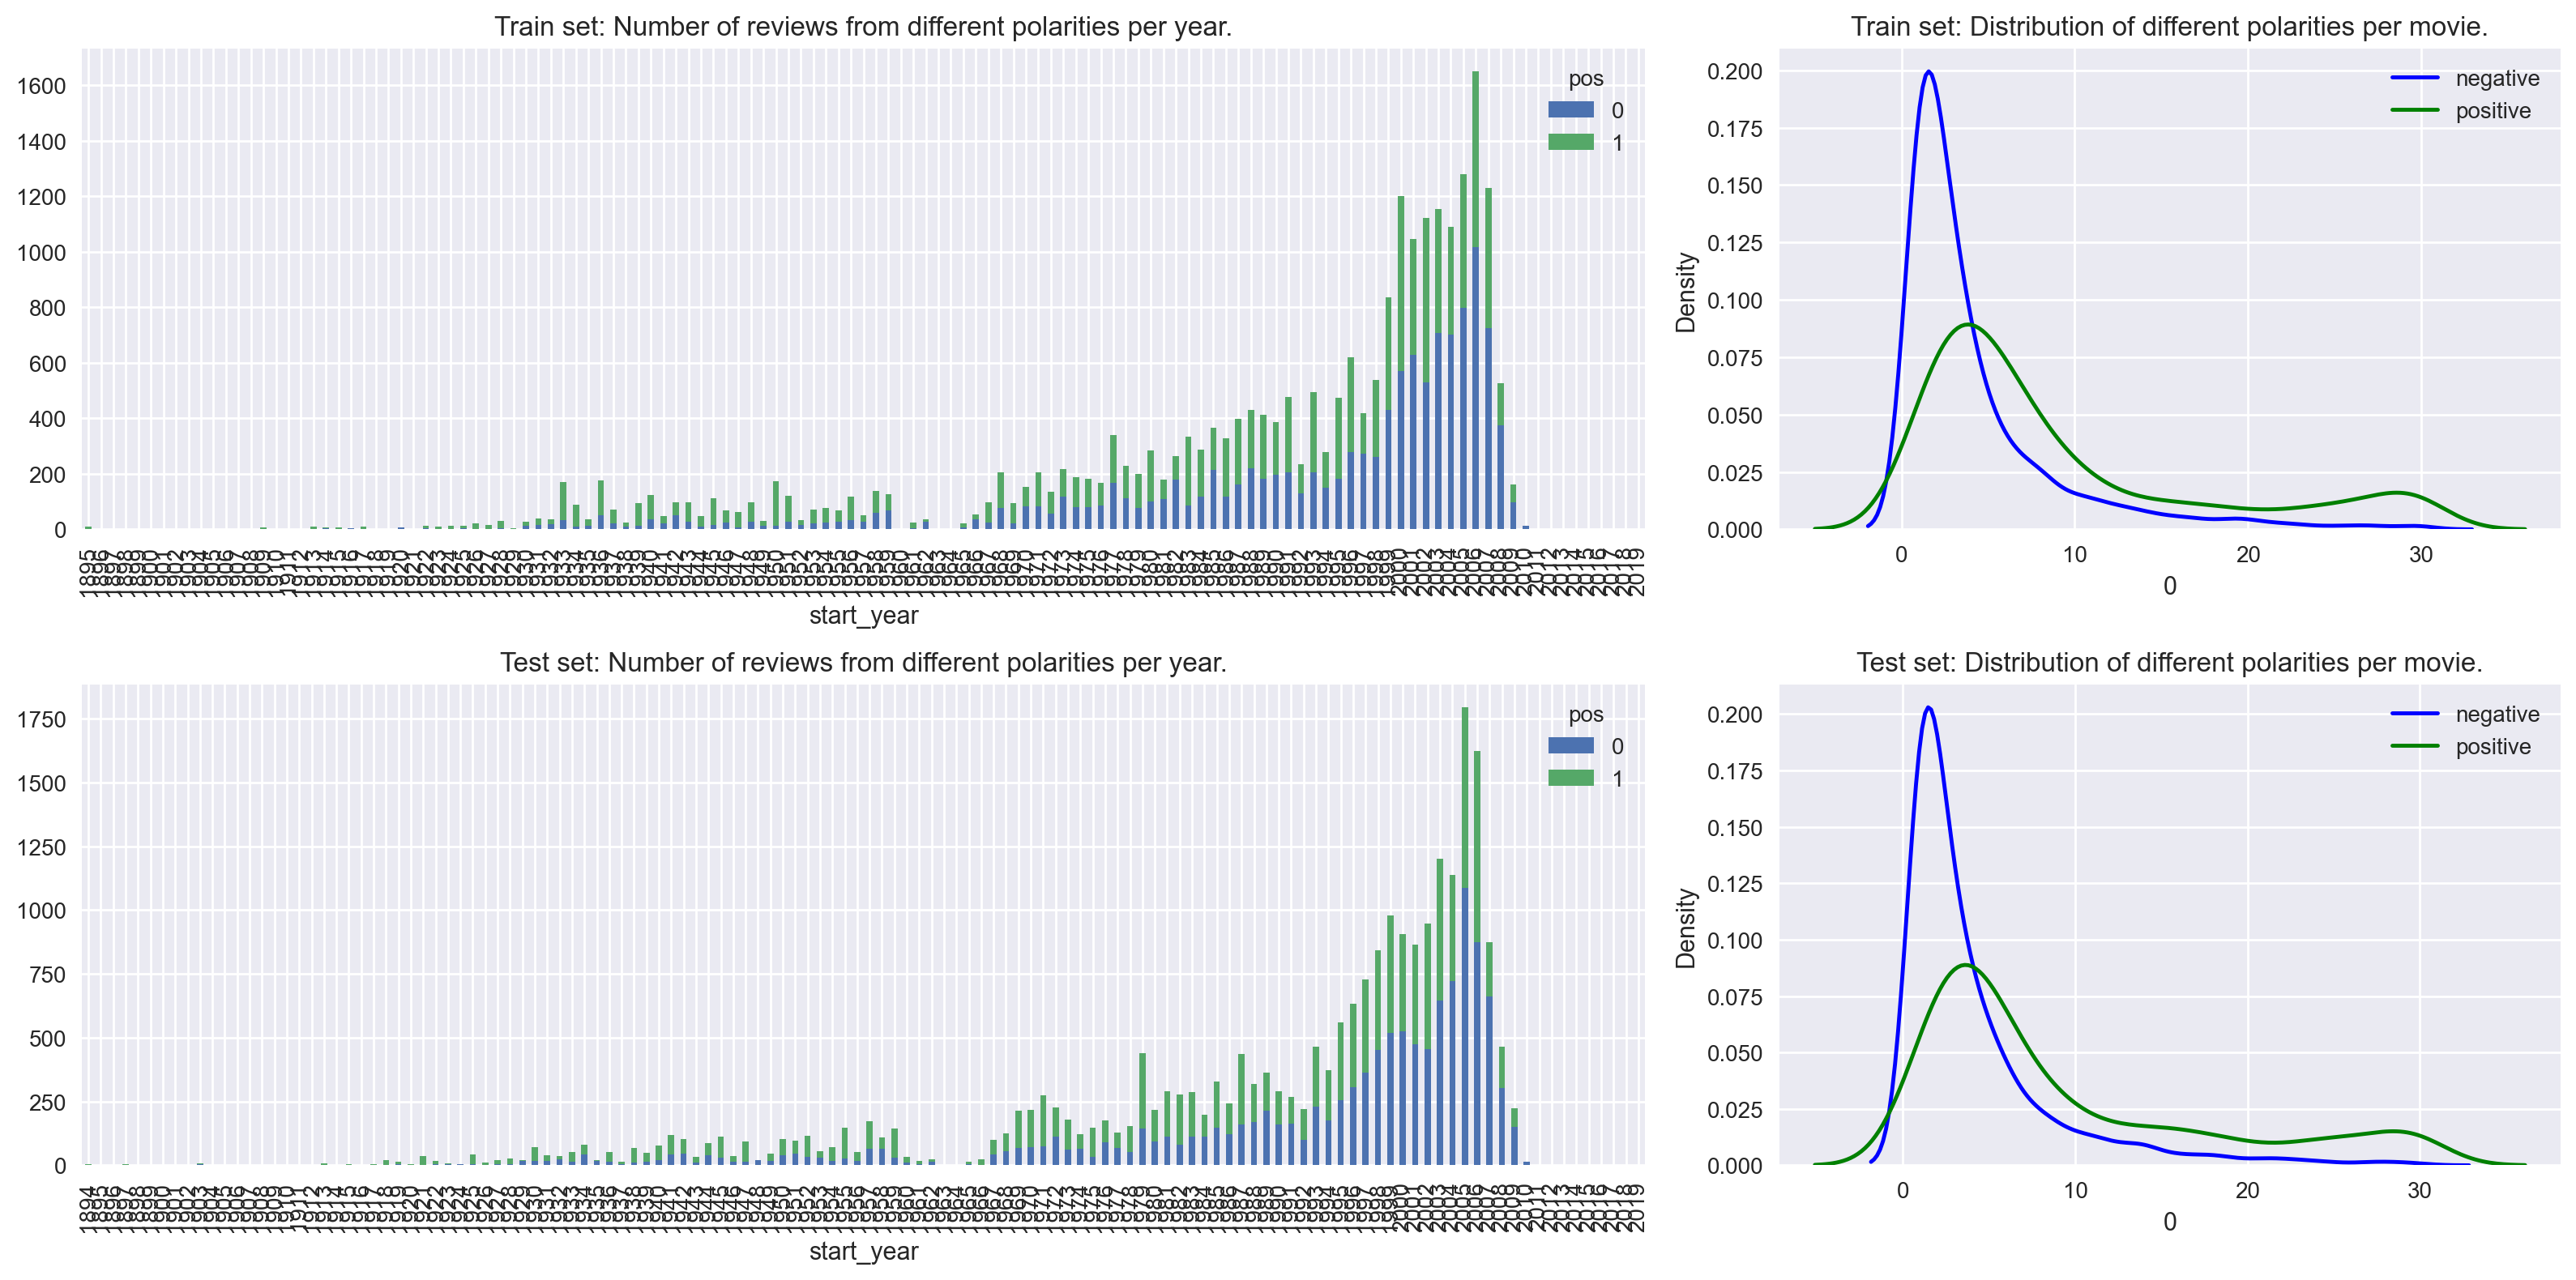

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train set: Number of reviews from different polarities per year.')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Train set: Distribution of different polarities per movie.')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: Number of reviews from different polarities per year.')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Test set: Distribution of different polarities per movie.')

fig.tight_layout()

**Findings**

1. From the comparison graphs of the Train Set and Test Set on the distribution of the number of reviews from different polarities per year, it can be observed that both datasets share a common trend, where negative reviews are more prevalent than positive reviews.
2. However, there are similarities and differences in the graphs depicting the number of reviews from different polarities per year. In the first rank, the year 2006 emerges as the year with the highest number of reviews in both datasets, with a count above 1600. However, the difference is apparent in the second rank, where in the Train Set, the second rank is in the year 2005. On the other hand, in the Test Set, the second rank is in the year 2007.

[Back to Contents](#back)

## 3. Data Preprocessing <a id='data_preprocessing'></a>

### 3.1 Normalization<a id='normalization'></a>

**Assumption**

We assume that all models below accept text in lowercase and without numbers, punctuation, etc.

In [19]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

In [20]:
# Before
df_reviews['review']

0        The pakage implies that Warren Beatty and Gold...
1        How the hell did they get this made?! Presenti...
2        There is no real story the film seems more lik...
3        Um .... a serious film about troubled teens in...
4        I'm totally agree with GarryJohal from Singapo...
                               ...                        
47326    This is another of my favorite Columbos. It sp...
47327    Talk about being boring! I got this expecting ...
47328    I never thought I'd say this about a biopic, b...
47329    Spirit and Chaos is an artistic biopic of Miya...
47330    I'll make this brief. This was a joy to watch....
Name: review, Length: 47331, dtype: object

In [21]:
# After
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made?! presenti...
2        there is no real story the film seems more lik...
3        um .... a serious film about troubled teens in...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos. it sp...
47327    talk about being boring! i got this expecting ...
47328    i never thought i'd say this about a biopic, b...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief. this was a joy to watch....
Name: review_norm, Length: 47331, dtype: object

**Findings**

From the application of the function above, the `review_norm` column has been transformed into lowercase and without special characters.

[Back to Contents](#back)

## 4. Model Training and Evaluation <a id='model_training_evaluation'></a>

In [23]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # Setting thresholds for multiple crossovers.
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # Setting thresholds for multiple crossovers.
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # Setting thresholds for multiple crossovers.
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy Score'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy score', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

**Note**

The `evaluate_model` function above is used to calculate F1, ROC, PRC, and for visualizing the evaluation metrics.

### 4.1 Splitting dataset into a training set and a test set <a id='splitting_dataset'></a>

Fortunately, the entire dataset has already been divided into train/test portions. The relevant flag is 'ds_part'.

In [24]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


### 4.2 Training Model <a id='training_model'></a>

### 4.2.1 Model 0 - Dummy Classifier Model (Constant) (baseline)

In [25]:
from sklearn.dummy import DummyClassifier

In [26]:
df = DummyClassifier(strategy = 'constant', constant = 1)
model_0 = df.fit(X = df_reviews_train, y = train_target)

                train  test
Accuracy score    NaN   NaN
F1               0.67  0.67
APS              0.50  0.50
ROC AUC          0.50  0.50


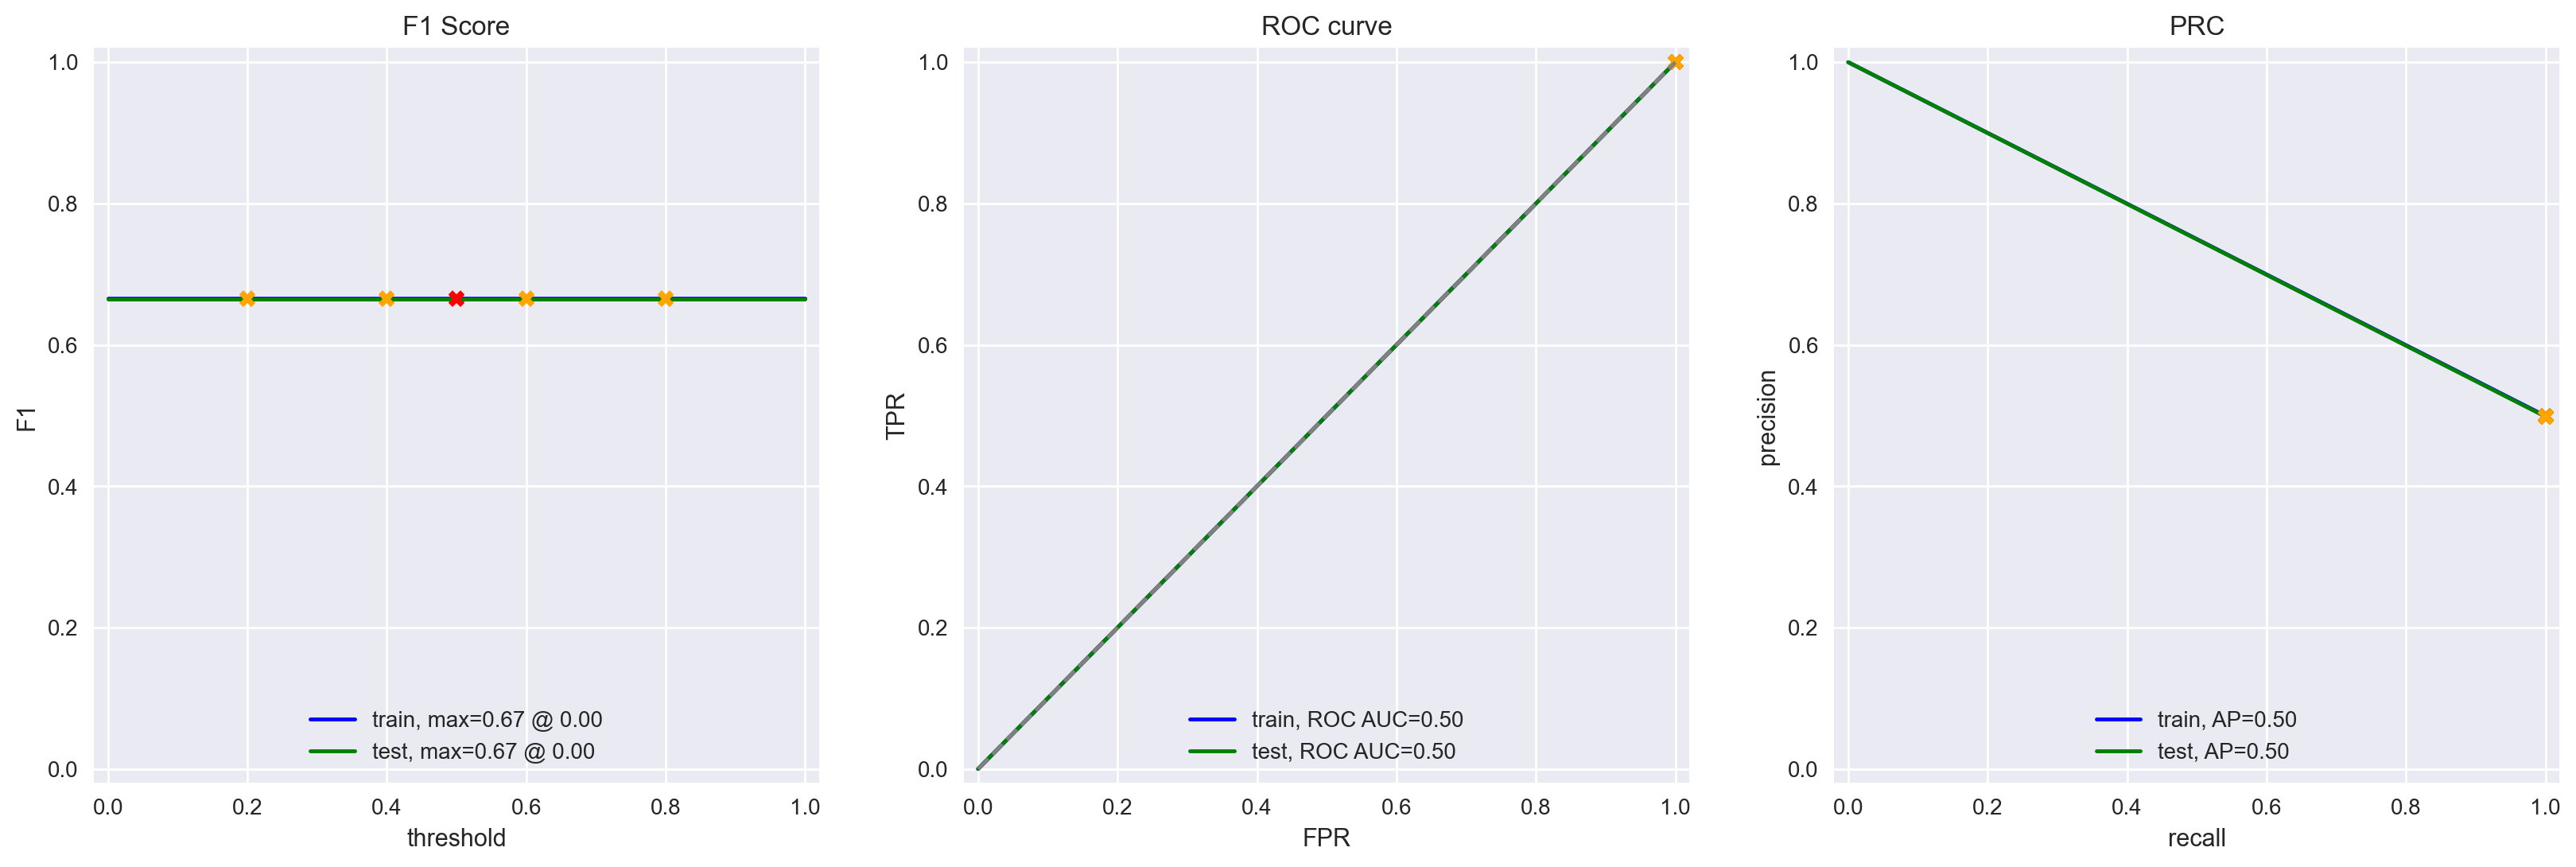

In [27]:
evaluate_model(model_0, np.empty(len(train_target)), train_target, np.empty(len(test_target)), test_target)

**Findings**

The result for model 0 (as a baseline) as follows,

|   |train|test|
|---|---|---|
|Accuracy score|NaN|NaN|
|F1|0.67|0.67|
|APS|0.50|0.50|
|ROC AUC|0.50|0.50|

The other trained models should have higher model evaluation scores than the baseline.

### 4.2.2 Model 1 - Linear Regression Model using the NLTK library for NLP task and TF-IDF for tokenization

In [28]:
import nltk

nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>


In [29]:
tfidf_nltk = TfidfVectorizer(stop_words = stopwords.words('english'), lowercase = True)

In [30]:
train_features_tfidf_nltk = tfidf_nltk.fit_transform(df_reviews_train['review_norm'])

In [31]:
train_features_tfidf_nltk.shape

(23796, 73081)

In [32]:
test_features_tfidf_nltk = tfidf_nltk.transform(df_reviews_test['review_norm'])

In [33]:
test_features_tfidf_nltk.shape

(23535, 73081)

In [34]:
lr = LogisticRegression()
model_1 = lr.fit(train_features_tfidf_nltk, train_target)

                train  test
Accuracy score    NaN   NaN
F1               0.94  0.88
APS              0.98  0.95
ROC AUC          0.98  0.95


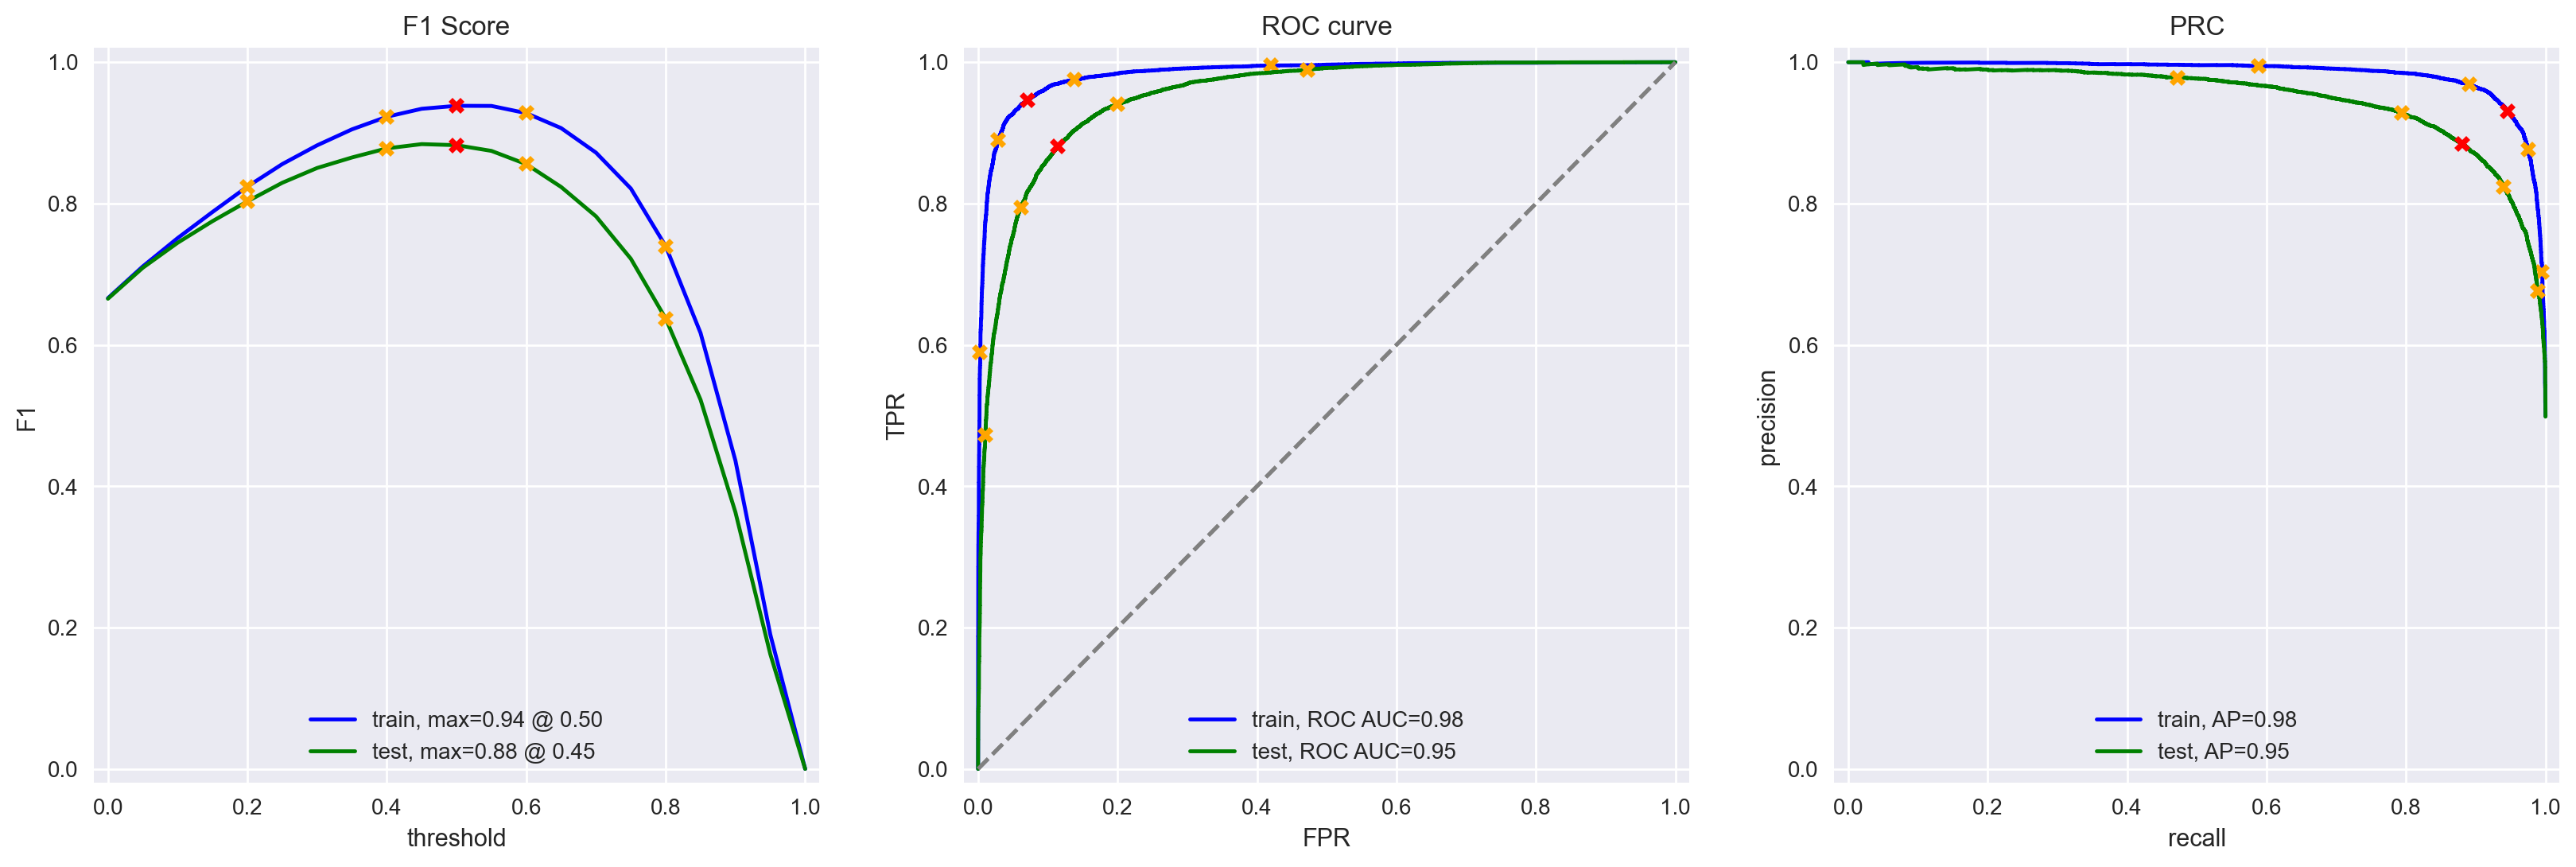

In [35]:
evaluate_model(model_1, train_features_tfidf_nltk, train_target, test_features_tfidf_nltk, test_target)

**Findings**

The result for model 1 as follows:

|   |train|test|
|---|---|---|
|Accuracy score|NaN|NaN|
|F1|0.94|0.88|
|APS|0.98|0.95|
|ROC AUC|0.98|0.95|

The accuracy values on the train set and test set have a difference of about 6 points. This could be one indicator that the model is experiencing overfitting.

#### 4.2.3 Model 2 - Hyperparameter Tuning for Model 1

In [36]:
tuned_lr = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 0.85)
model_2 = tuned_lr.fit(train_features_tfidf_nltk, train_target)

                train  test
Accuracy score    NaN   NaN
F1               0.89  0.88
APS              0.96  0.94
ROC AUC          0.96  0.95


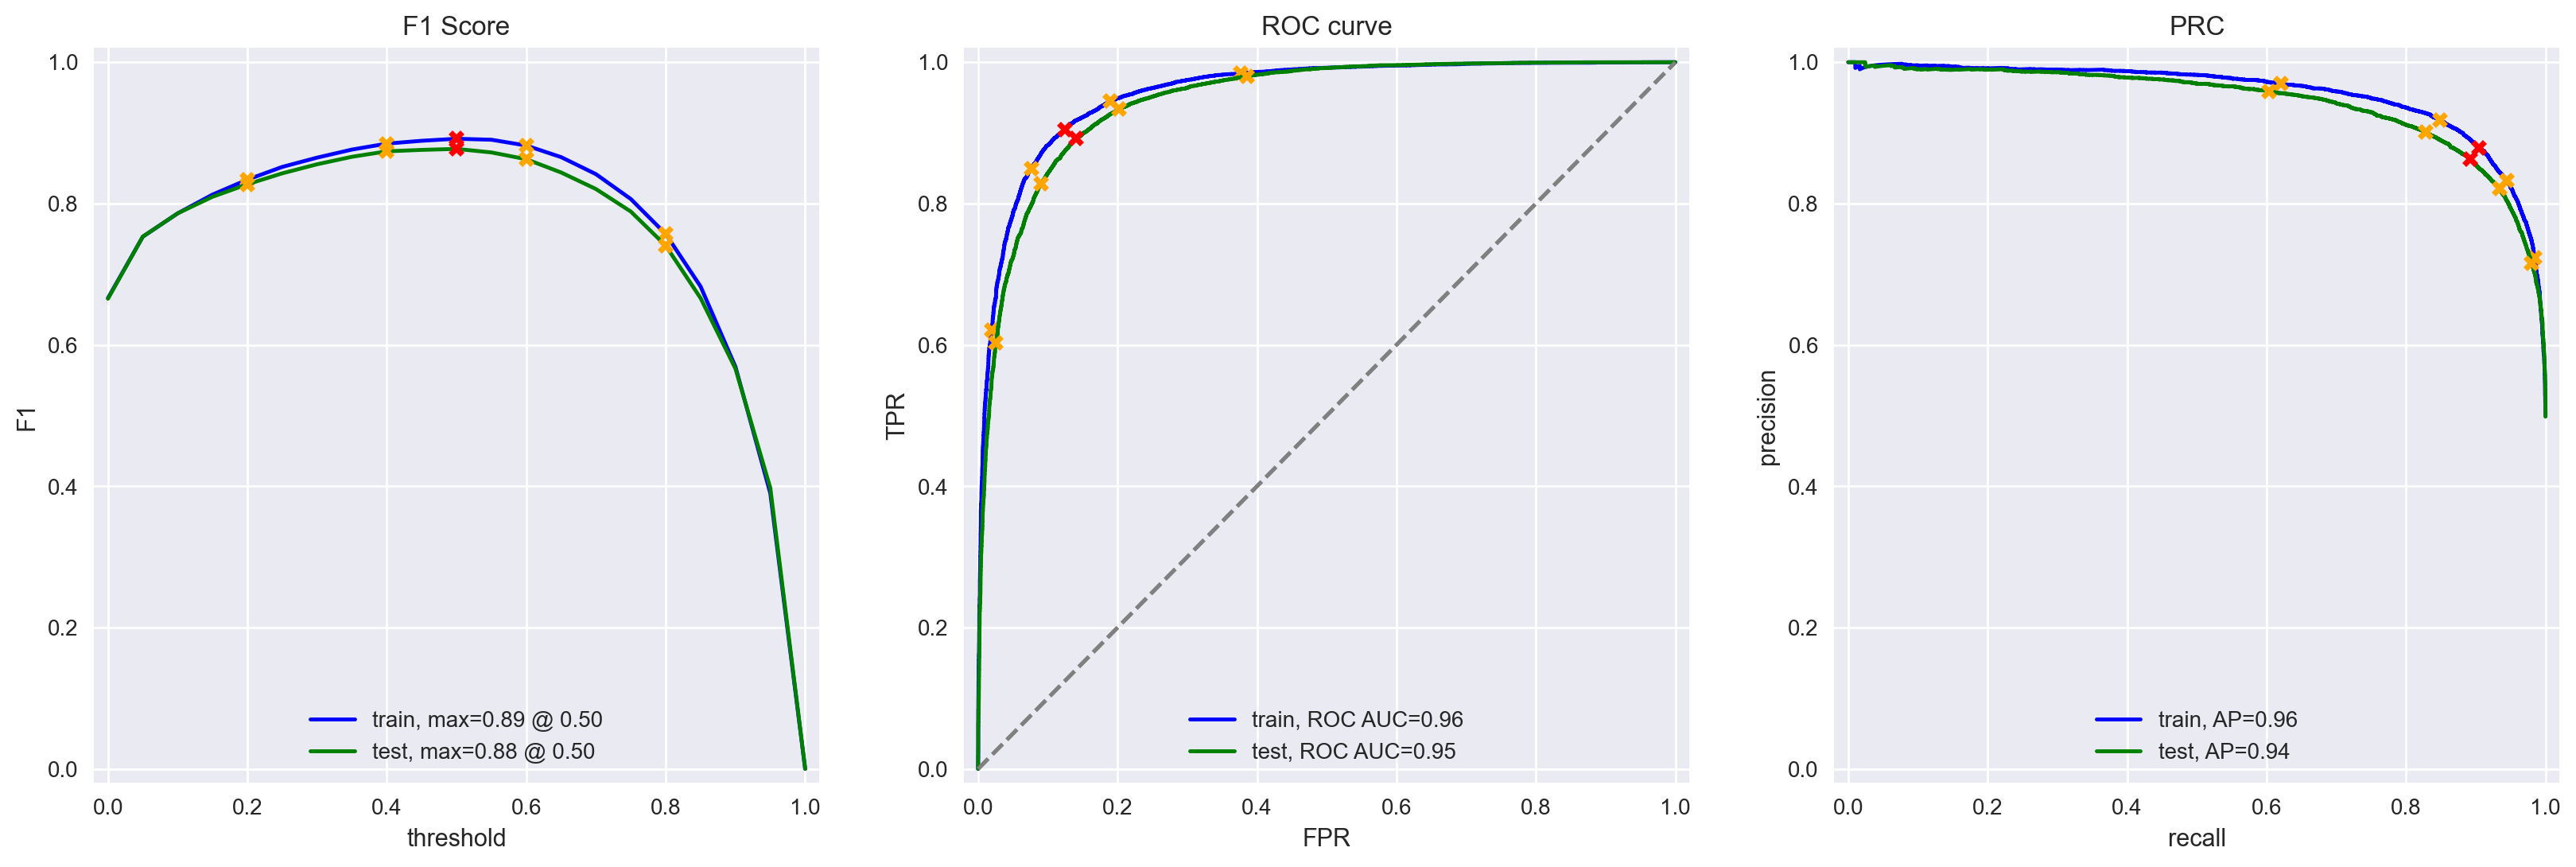

In [37]:
evaluate_model(model_2, train_features_tfidf_nltk, train_target, test_features_tfidf_nltk, test_target)

**Findings**

The result for model 2 as follows:

|   |train|test|
|---|---|---|
|Accuracy score|NaN|NaN|
|F1|0.89|0.88|
|APS|0.96|0.94|
|ROC AUC|0.96|0.95|

From the results above, it can be observed that the model is no longer experiencing overfitting, as the difference between the train set and test set is small.

#### 4.2.4 Model 3 - Linear Regression Model using spaCy libary for NLP task and TF-IDF for tokenization

In [39]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [41]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [42]:
df_reviews_train['review_tokenizer3'] = df_reviews_train['review'].apply(lambda x: text_preprocessing_3(x))

In [43]:
df_reviews_test['review_tokenizer3'] = df_reviews_test['review'].apply(lambda x: text_preprocessing_3(x))

In [44]:
df_reviews_train['review_tokenizer3'].head

<bound method NDFrame.head of 0        the pakage imply that Warren Beatty and Goldie...
1        how the hell do they get this make ? ! present...
7        this true story of Carlson 's Raiders be more ...
8        should have be title ' balderdash ! ' little i...
9        the movie ' Gung Ho ! ' : the Story of Carlson...
                               ...                        
47253    o my gosh ... just give I a minute to breath ....
47254    I can not tell you all how much I love this mo...
47255    Legend of Zu be possibly the most exciting mov...
47256    this movie be well do on so many level that I ...
47257    as a history nut who be particularly intereste...
Name: review_tokenizer3, Length: 23796, dtype: object>

In [45]:
df_reviews_test['review_tokenizer3'].head()

2    there be no real story the film seem more like...
3    um .... a serious film about troubled teen in ...
4    I be totally agree with GarryJohal from Singap...
5    this be the first movie I 've see from Singapo...
6    yes non - Singaporean 's can not see what be t...
Name: review_tokenizer3, dtype: object

In [46]:
tfidf_spacy = TfidfVectorizer()

In [47]:
train_features_tfidf_spacy = tfidf_spacy.fit_transform(df_reviews_train['review_tokenizer3'])

In [48]:
train_features_tfidf_spacy.shape

(23796, 62855)

In [49]:
test_features_tfidf_spacy = tfidf_spacy.transform(df_reviews_test['review_tokenizer3'])

In [50]:
test_features_tfidf_spacy.shape

(23535, 62855)

In [51]:
lr3 = LogisticRegression()
model_3 = lr3.fit(train_features_tfidf_spacy, train_target)

                train  test
Accuracy score    NaN   NaN
F1               0.93  0.88
APS              0.98  0.95
ROC AUC          0.98  0.95


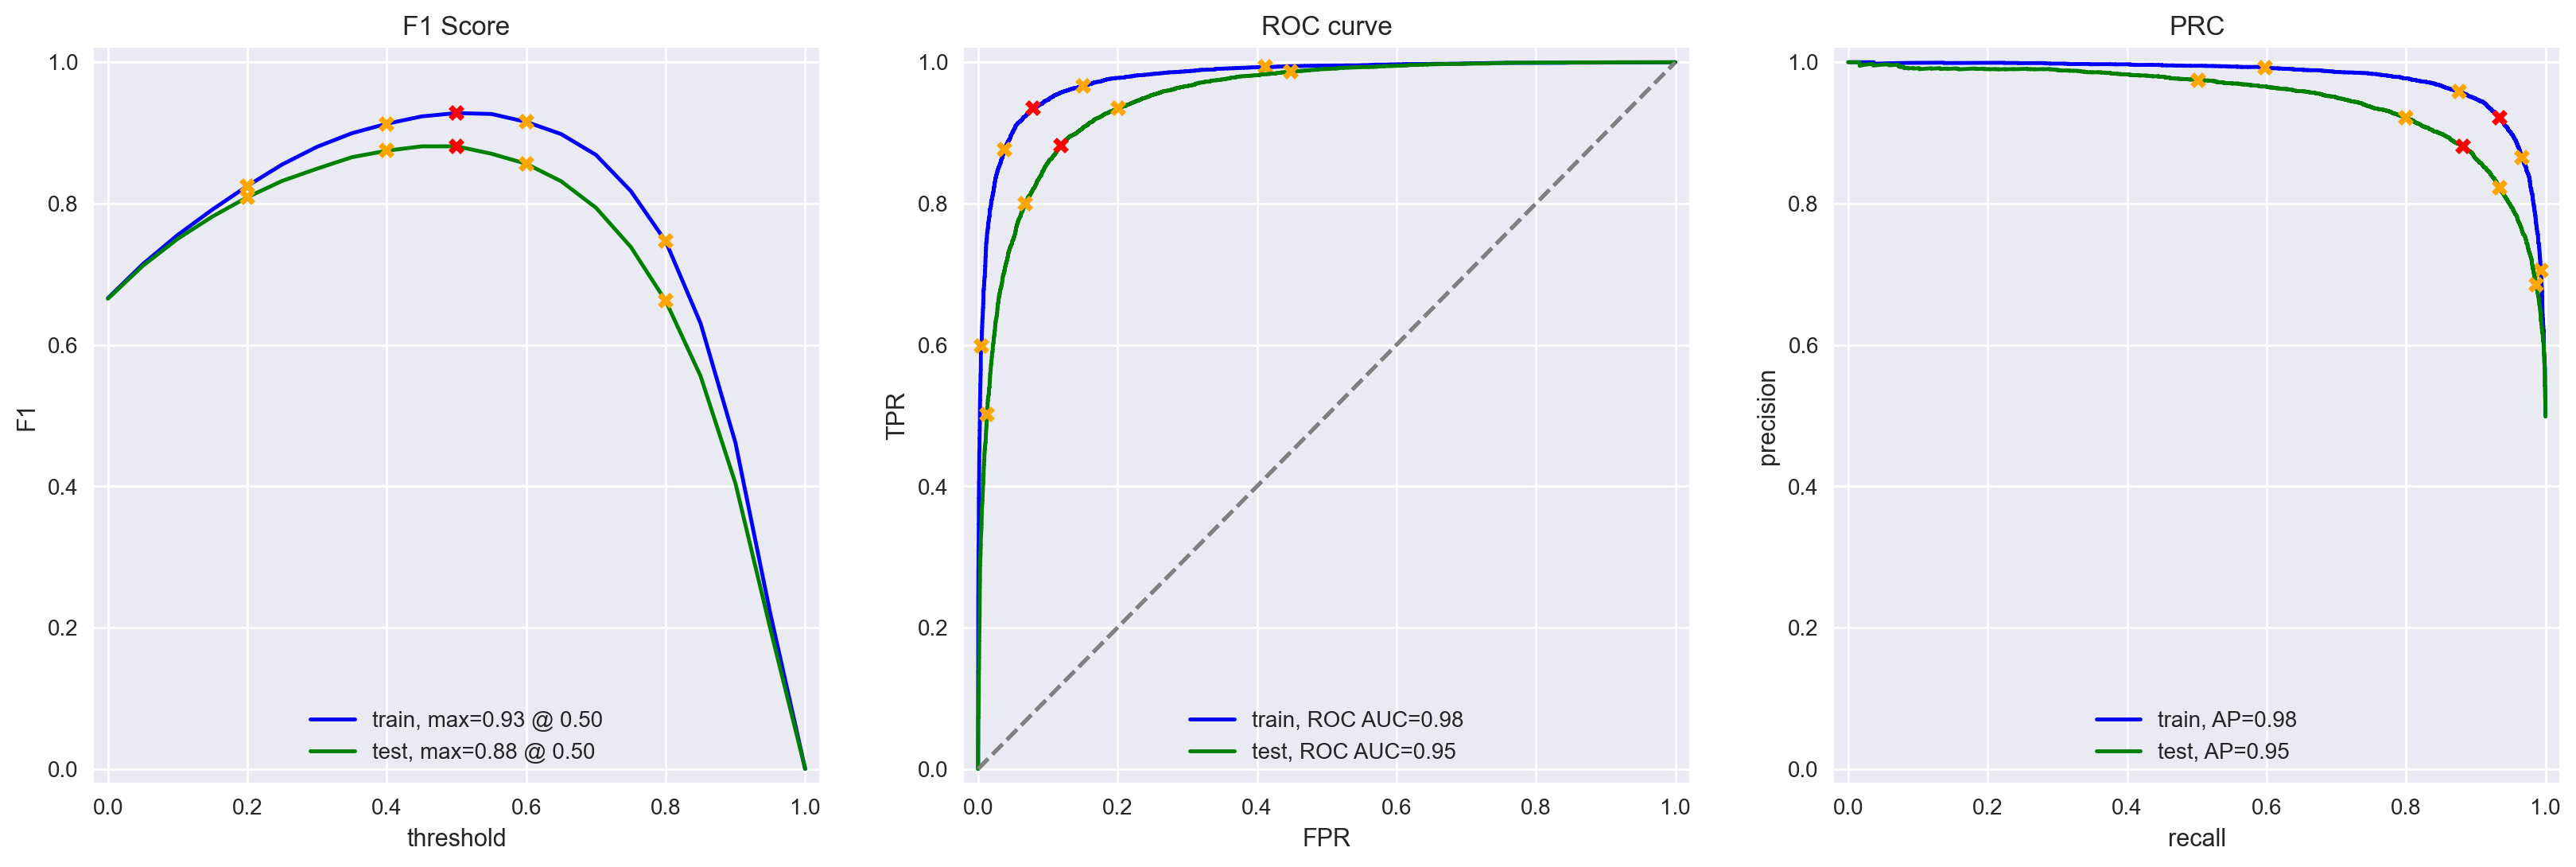

In [52]:
evaluate_model(model_3, train_features_tfidf_spacy, train_target, test_features_tfidf_spacy, test_target)

**Findings**

The result for model 3 as follows:

|   |train|test|
|---|---|---|
|Accuracy score|NaN|NaN|
|F1|0.93|0.88|
|APS|0.98|0.95|
|ROC AUC|0.98|0.95|

The accuracy values on the train set and test set have a difference of about 5 points. This could be one indicator that the model is experiencing overfitting.

#### 4.2.5 Model 4 - Hyperparameter Tuning for Model 3

In [53]:
tuning_lr3 = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 0.85)
model_4 = tuning_lr3.fit(train_features_tfidf_spacy, train_target)

                train  test
Accuracy score    NaN   NaN
F1               0.89  0.88
APS              0.96  0.94
ROC AUC          0.96  0.95


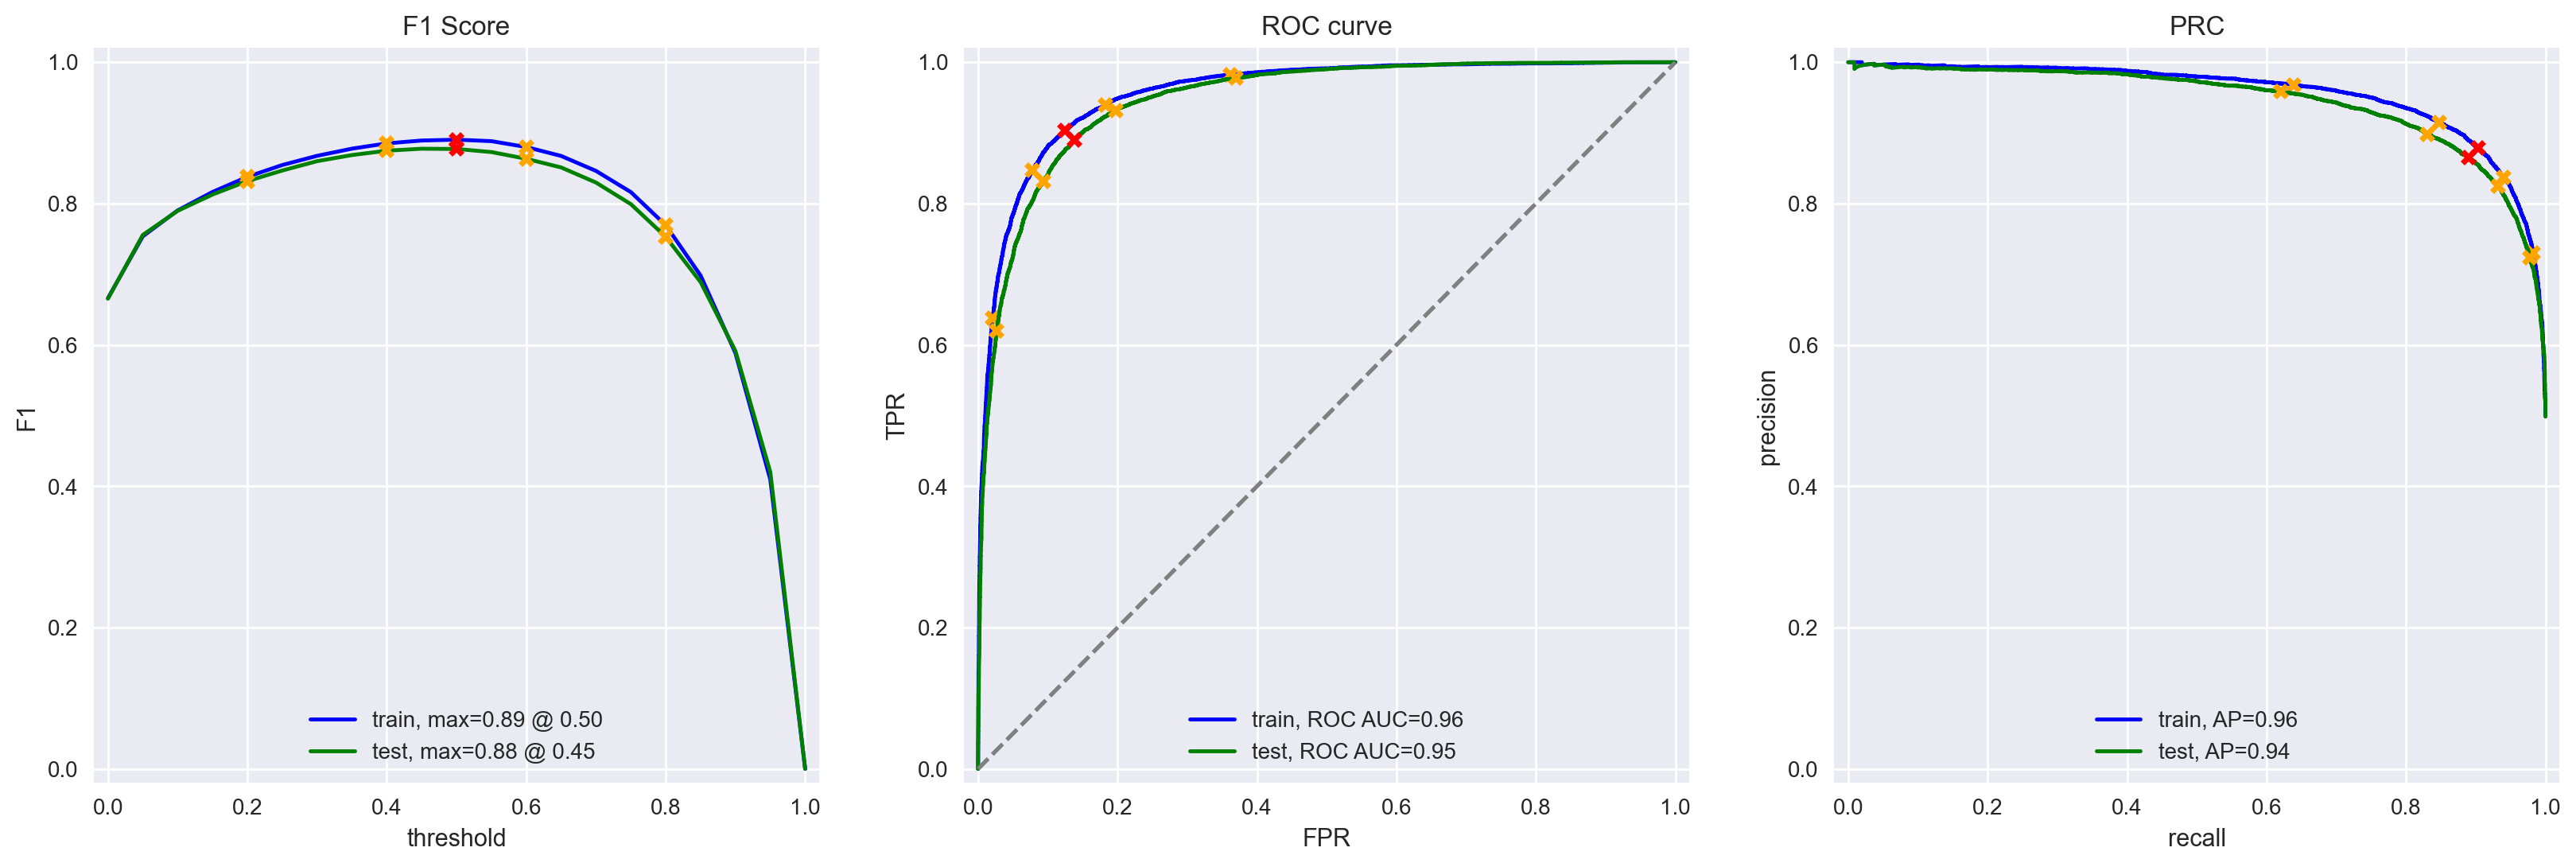

In [54]:
evaluate_model(model_4, train_features_tfidf_spacy, train_target, test_features_tfidf_spacy, test_target)

**Findings**

The result for model 4 as follows:

|   |train|test|
|---|---|---|
|Accuracy score|NaN|NaN|
|F1|0.89|0.88|
|APS|0.96|0.94|
|ROC AUC|0.96|0.95|


From the results above, it can be seen that the values in Model 4 (after hyperparameter tuning in Model 3) are the same as those in Model 2, but with significantly different processing times.


When using the spaCy library, lemmatization processing takes a long time. Considering this, Model 2 is preferable over Model 4.

#### 4.2.6 Model 5 - LGBMClassifier model using spaCy library for NLP task and TF-IDF for tokenization

I will reuse `train_features_tfidf_spacy` and `test_features_tfidf_spacy` that have been processed in the previous model (model 3).

In [60]:
from lightgbm import LGBMClassifier

In [61]:
model_5 = LGBMClassifier(learning_rate = 0.01, max_depth = 10)
model_5.fit(train_features_tfidf_spacy, train_target)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.939224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 486792
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9716
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


LGBMClassifier(learning_rate=0.01, max_depth=10)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
                train  test
Accuracy score    NaN   NaN
F1               0.80  0.78
APS              0.87  0.85
ROC AUC          0.87  0.86


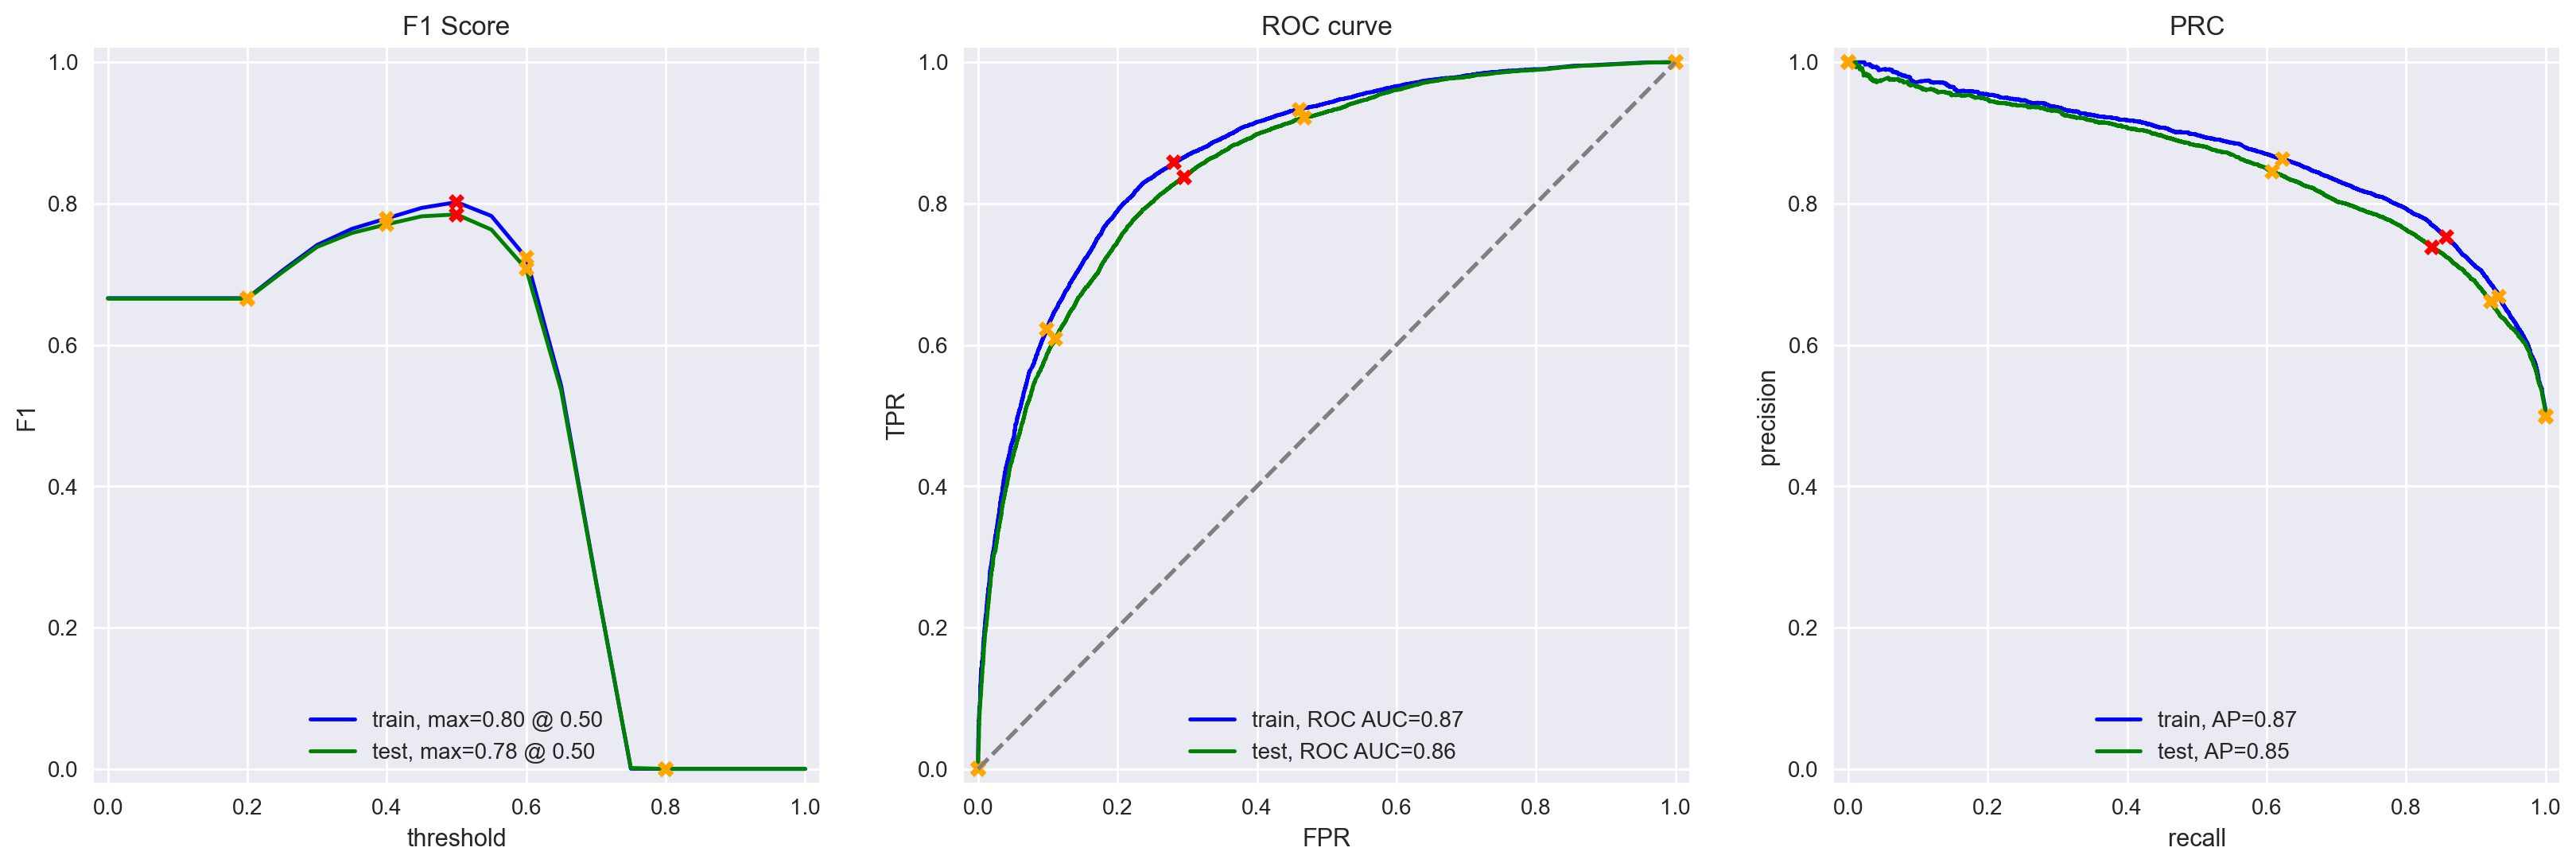

In [62]:
evaluate_model(model_5, train_features_tfidf_spacy, train_target, test_features_tfidf_spacy, test_target)

**Findings**

The result for model 5 as follows:

|   |train|test|
|---|---|---|
|Accuracy score|NaN|NaN|
|F1|0.80|0.78|
|APS|0.87|0.85|
|ROC AUC|0.87|0.86|


Model 4 and Model 2 have higher evaluation scores than Model 5.

[Back to Contents](#back)

## 5. Testing the trained model on a self-created reviews dataset <a id='testing_selfcreated_dataset'></a>

In [63]:
my_reviews = pd.DataFrame([
            "I do not like it, it is not my favorite kind of movie.",
            "Boring, I even fell asleep in the middle of the film.",
            "The movie is really good, I really like it.",
            "Even the actors looked very old and disinterested in the film. Are they getting paid to act in this? Truly low-quality.",
            "I didn't expect the movie to be this good! The writers really paid attention to every detail.",
            "This film has its strengths and weaknesses, but overall, I think it's a worthy movie. I might watch it again.",
            "Some of the jokes are really not funny. Not a single joke landed, everyone is annoying, even kids wouldn't like this!",
            "Airing this movie on Netflix is a bold move, and I'm thrilled to be able to watch episode after episode of this exciting and intelligent new drama."
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: text_preprocessing_3(x))

my_reviews

,review,review_norm
0,"I do not like it, it is not my favorite kind o...","I do not like it , it be not my favorite kind ..."
1,"Boring, I even fell asleep in the middle of th...","Boring , I even fall asleep in the middle of t..."
2,"The movie is really good, I really like it.","the movie be really good , I really like it ."
3,Even the actors looked very old and disinteres...,even the actor look very old and disintereste ...
4,I didn't expect the movie to be this good! The...,I do not expect the movie to be this good ! th...
5,"This film has its strengths and weaknesses, bu...","this film have its strength and weakness , but..."
6,Some of the jokes are really not funny. Not a ...,some of the joke be really not funny . not a s...
7,"Airing this movie on Netflix is a bold move, a...","air this movie on Netflix be a bold move , and..."


### 5.1 Testing Model <a id='testing_model'></a>

#### 5.1.1 Model 1 (Linear Regression Model using the NLTK library for NLP task and TF-IDF for tokenization)

In [64]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_nltk.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.87:  I do not like it , it be not my favorite kind of movie .
0.02:  Boring , I even fall asleep in the middle of the film .
0.53:  the movie be really good , I really like it .
0.10:  even the actor look very old and disintereste in the film . be they get pay to act in this ? truly l
0.54:  I do not expect the movie to be this good ! the writer really pay attention to every detail .
0.63:  this film have its strength and weakness , but overall , I think it be a worthy movie . I might watc
0.03:  some of the joke be really not funny . not a single joke land , everyone be annoying , even kid woul
0.81:  air this movie on Netflix be a bold move , and I be thrilled to be able to watch episode after episo


#### 5.1.2 Model 3 (Linear Regression Model using spaCy libary for NLP task and TF-IDF for tokenization)

In [65]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.86:  I do not like it , it be not my favorite kind of movie .
0.01:  Boring , I even fall asleep in the middle of the film .
0.89:  the movie be really good , I really like it .
0.12:  even the actor look very old and disintereste in the film . be they get pay to act in this ? truly l
0.36:  I do not expect the movie to be this good ! the writer really pay attention to every detail .
0.80:  this film have its strength and weakness , but overall , I think it be a worthy movie . I might watc
0.01:  some of the joke be really not funny . not a single joke land , everyone be annoying , even kid woul
0.86:  air this movie on Netflix be a bold move , and I be thrilled to be able to watch episode after episo


#### 5.1.3 Model 5 (LGBMClassifier model using spaCy library for NLP task and TF-IDF for tokenization)

In [66]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_spacy
my_reviews_pred_prob = model_5.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.55:  I do not like it , it be not my favorite kind of movie .
0.45:  Boring , I even fall asleep in the middle of the film .
0.62:  the movie be really good , I really like it .
0.61:  even the actor look very old and disintereste in the film . be they get pay to act in this ? truly l
0.53:  I do not expect the movie to be this good ! the writer really pay attention to every detail .
0.61:  this film have its strength and weakness , but overall , I think it be a worthy movie . I might watc
0.53:  some of the joke be really not funny . not a single joke land , everyone be annoying , even kid woul
0.64:  air this movie on Netflix be a bold move , and I be thrilled to be able to watch episode after episo


[Back to Contents](#back)

# General Conclusion <a id='end'></a>

We have trained the following models:

- Dummy Classifier - Model 0
- Linear Regression Model using the NLTK library for NLP task and TF-IDF for tokenization [without hyperparameter tuning and with hyperparameter tuning] - Models 1 and 2
- Linear Regression Model using the spaCy library for NLP task and TF-IDF for tokenization [without hyperparameter tuning and with hyperparameter tuning] - Models 3 and 4
- LGBMClassifier model using the spaCy library for NLP task and TF-IDF for tokenization - Model 5

Out of the five trained models, the best model for predicting negative comments is Model 2: Linear Regression Model using the NLTK library for NLP task and TF-IDF for tokenization with hyperparameter tuning.

The processing time is faster compared to Model 4. When applied to the self-created review dataset, the results of model 2 are reasonably accurate, although there are some predictions that are not entirely accurate.

[Back to Contents](#back)